In [1]:
using Pkg
Pkg.instantiate()

In [2]:
#import Pkg; Pkg.add("NIfTI")
using NIfTI                  
#import Pkg; Pkg.add("RegressionDynamicCausalModeling")
using RegressionDynamicCausalModeling
using Statistics
#import Pkg; Pkg.add("StatsBase")
using StatsBase #for spearman
#import Pkg; Pkg.add("Plots")
using Plots
using Random

using DelimitedFiles
using MAT            # for saving .mat files
using Glob
using Printf

In [3]:
function extract_timeseries(subject::String; 
                             data_dir::String="/Users/schmieschekm/Desktop/dpabi_final/FunImgARCFW", 
                             mask_dir::String="/Users/schmieschekm/Desktop/dpabi_final/Brainnetome2016/BNA_PM_3D_246_bin_unzip")
    # 1) load rsfMRI
    func_path = joinpath(data_dir, subject, "wFiltered_4DVolume.nii")
    fmri = niread(func_path)                     # NIfTI.jl :contentReference[oaicite:2]{index=2}
    vol4d = fmri.raw                             # raw array dims (X,Y,Z,T)
    T = size(vol4d,4)                            # number of timepoints
    TR = time_step(fmri.header) / 1000           # header dt in ms → seconds
    println("func size = ", size(vol4d))

    # 2) list all masks and preallocate
    mask_files = sort(readdir(mask_dir))
    nroi = length(mask_files)
    ts = zeros(nroi, T)

    # 3) loop over masks, extract ROI‐mean
    vol2d = reshape(vol4d, :, T)  # voxels × time
    for (i, mf) in enumerate(mask_files)
        mnii = niread(joinpath(mask_dir, mf))
        println("mask size = ", size(mnii))
        mask = mnii.raw .> 0                      # boolean mask :contentReference[oaicite:3]{index=3}
        roi_data = vol2d[vec(mask), :]            # select masked voxels
        ts[i, :] = mean(roi_data; dims=1)[:]      # mean across voxels
    end

    return ts, TR, mask_files
end

extract_timeseries (generic function with 1 method)

In [4]:
function extract_timeseries_by_label(func_dir::String, func_fileName::String, atlas_dir::String, atlas_fileName::String, subject::String)
    # 1) load data
    func_path = joinpath(func_dir, subject, func_fileName)
    println(func_path)
    atlas_path = joinpath(atlas_dir, atlas_fileName)
    func_nii  = niread(func_path)
    atlas_nii = niread(atlas_path)

    vol4d = func_nii.raw                     # Float32[X,Y,Z,T]
    atlas = atlas_nii.raw                    # Int or Float labels [X,Y,Z]
    dims3 = size(atlas)
    T     = size(vol4d, 4)
    TR    = time_step(func_nii.header) / 1000  # ms → s

    # flatten spatial dims
    vol2d = reshape(vol4d, prod(dims3), T)     # (voxels × time)
    atlas1 = vec(atlas)                        # (voxels)

    # 2) find unique nonzero labels
    regs = sort(unique(atlas1))
    regs = filter(!=(0), regs)                 # drop background 0

    # 3) for each label, average the voxels
    nreg = length(regs)
    ts   = zeros(Float64, nreg, T)

    for (i, lbl) in enumerate(regs)
        mask_vec = atlas1 .== lbl              # Bool[voxels]
        if !any(mask_vec)
            @warn "No voxels found for label $lbl in atlas"
            continue
        end
        roi_data = vol2d[mask_vec, :]          # (nVoxels × T)
        ts[i, :] = mean(roi_data; dims=1)[:]   # 1×T → T
    end

    return ts, regs, TR
end

extract_timeseries_by_label (generic function with 1 method)

In [5]:
function compute_functional_connectivity(ts::AbstractMatrix{<:Real};
                                         method::Symbol = :pearson,
                                         fisher_z::Bool = false)
    nroi, _ = size(ts)
    C = zeros(Float64, nroi, nroi)

    if method == :pearson
        for i in 1:nroi
            for j in i:nroi
                r = cor(ts[i, :], ts[j, :])
                if fisher_z
                    # clamp to avoid infinities
                    r_clamped = clamp(r, -0.9999, 0.9999)
                    val = atanh(r_clamped)
                else
                    val = r
                end
                C[i, j] = val
                C[j, i] = val
            end
        end

    elseif method == :covariance
        # cov(ts') returns ROI×ROI covariance
        C = cov(ts')
    else
        throw(ArgumentError("Unsupported method: $method; choose :pearson or :covariance"))
    end

    return C
end

compute_functional_connectivity (generic function with 1 method)

In [6]:
function estimate_rdcm(ts::Matrix{Float64}, TR::Float64; verbose::Int=1, A::BitMatrix=nothing)
    nroi, scans = size(ts)
    #print(scans)

    # 1) endogenous A‐matrix (fully connected minus self‐connections) >> changing to Brainnetome later
    

    # 2) no driving inputs
    C = falses(nroi, 0)

    # 3) package the BOLD data: expects scans×regions
    Y    = RegressionDynamicCausalModeling.BoldY(ts', TR, nothing)  # :contentReference[oaicite:1]{index=1}

    # 4) no confounds
    r_dt = 16
    u_dt = TR / r_dt
    X_numOfSteps =  round(Int64, scans * TR / u_dt)
    #println("X_numOfSteps: ", X_numOfSteps)

    Conf = RegressionDynamicCausalModeling.Confound(zeros(X_numOfSteps, 0), String[])
   # println("Confound finished ")

    # 5) zero initial parameters for A and C
    Ep   = RegressionDynamicCausalModeling.TrueParamLinear(
               zeros(nroi, nroi),      # A‐parameters
               zeros(nroi, 0)           # C‐parameters
           )

    # 6) build a LinearDCM and convert to rigid rDCM
    dcm  = RegressionDynamicCausalModeling.LinearDCM(A, C, scans, nroi, nothing, Y, Ep, Conf)
    rdcm = RegressionDynamicCausalModeling.RigidRdcm(dcm)             # :contentReference[oaicite:2]{index=2}

    # 7) set inversion options and invert
    invpars = RegressionDynamicCausalModeling.RigidInversionParams()   # default maxIter, tol
    opt     = RegressionDynamicCausalModeling.Options(invpars; synthetic=false, verbose=verbose)
    output  = RegressionDynamicCausalModeling.invert(rdcm, opt)        # :contentReference[oaicite:3]{index=3}

    return rdcm, output
end


estimate_rdcm (generic function with 1 method)

In [32]:
func_dir =  "C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW"
connect_dir =  "C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/connectivity"

func_fileName = "wFiltered_4DVolume.nii"

atlas_dir= "C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data"
atlas_fileName = "BN_Atlas_246_3mm.nii"

subject_folders = filter(isdir, readdir(func_dir, join=true))
subject_ids = [basename(folder) for folder in subject_folders]

A_array = readdlm("BNA_matrix_binary_246x246.csv", ',', Int)
A_matrix = BitMatrix(A_array .== 1)
verbose = 1

# --- Loop through subjects ---
for subject in subject_ids
    println("Extracting time series")
    ts, labels, TR = extract_timeseries_by_label(func_dir, func_fileName, atlas_dir, atlas_fileName, subject)

    println("Estimate rDCM")
    rdcm, output = estimate_rdcm(ts, TR, verbose=verbose, A=A_matrix)

    println("Extracted $(length(labels)) region time series, TR=$(TR)s")
    println("Estimate Functional Connectivity")

    fc_mat = compute_functional_connectivity(ts)              # Pearson r
    fc_z   = compute_functional_connectivity(ts; fisher_z=true)  # Fisher-z
    cov_mat = compute_functional_connectivity(ts; method=:covariance)  # Covariance

    save_path = joinpath(connect_dir, subject, "Connectivity_analysis_results.mat")
    mkpath(dirname(save_path))  # Ensure directory exists

    # Save to .mat file
    MAT.matwrite(save_path, Dict(
        "ts" => ts,
        "labels" => labels,
        "TR" => TR,
        "output_m_all" => output.m_all,
        "fc_mat" => fc_mat,
        "fc_z" => fc_z,
        "cov_mat" => cov_mat
    ))
end

 

Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0006315\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0080428\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0088343\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0119126\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0120313\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0127024\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0129331\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0130013\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0140824\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0141624\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0162531\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0166034\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0168240\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Extracted 246 region time series, TR=2.924999952316284s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0171027\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0177342\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0177544\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0177746\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0178647\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0185442\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.924999952316284s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0191437\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0191942\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0193138\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Extracted 246 region time series, TR=2.924999952316284s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0197752\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Extracted 246 region time series, TR=2.924999952316284s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0199554\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0203115\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0204319\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.924999952316284s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0204420\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0212318\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0214625\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0215122\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0216932\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0217126\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=3.0s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0220923\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0224931\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.924999952316284s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0225327\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0237738\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0238942\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.924999952316284s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0244028\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0244533\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0258140\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.924999952316284s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0258443\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Extracted 246 region time series, TR=2.9000000953674316s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0258948\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


Extracted 246 region time series, TR=2.924999952316284s
Estimate Functional Connectivity
Extracting time series
C:/Users/fabia/lubaCloud2/iCloudDrive/Documents/Documents - MacBook Pro — Lyubov/ETH/Courses/Translational Neuromodeling/data/FunImgARCFW\0261230\wFiltered_4DVolume.nii
Estimate rDCM
Running model inversion (rigid rDCM)


Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:00Excessive output truncated after 524420 bytes.

In [31]:
#reading the .mat file

# Define the path to your .mat file
subject = "0006315"
save_path = joinpath(func_dir, subject, "Connectivity_analysis_results.mat")

# Read the contents
data = matread(save_path)

# Access variables from the dictionary
ts = data["ts"]
labels = data["labels"]
TR = data["TR"]
output_m_all = data["output_m_all"]
fc_mat = data["fc_mat"]
fc_z = data["fc_z"]
cov_mat = data["cov_mat"]

246×246 Matrix{Float64}:
 156.906     39.3108     82.1608    …  -22.5178     43.2521     36.3381
  39.3108    48.0917     20.569          4.46358     9.29643     6.74766
  82.1608    20.569     126.852        -34.5837     12.487       6.13679
 103.079     28.5024     82.2527       -32.9256     32.802      45.285
  28.3344    10.9149     52.6921       -21.4502      3.08163    -0.852981
  24.8635    -0.795466   52.5573    …   15.2345     -0.747862   -0.660723
  19.4602    30.8711     19.0248       -24.8282      7.07563    -3.41153
  -9.45052   32.9821      5.11874      -23.0065     -2.30597     0.220304
  82.7271    20.7691     -6.41232       -7.86074    41.4843     25.6306
  16.9028    15.5291     -7.38478       -9.23264    11.728       7.17059
   ⋮                                ⋱                            ⋮
  66.3124    -0.207451   12.6337         6.41946    23.8567     81.3676
   2.07513   -3.8413     -1.71934        0.805079   16.5258      6.96462
  18.8052     5.93891     0.914955

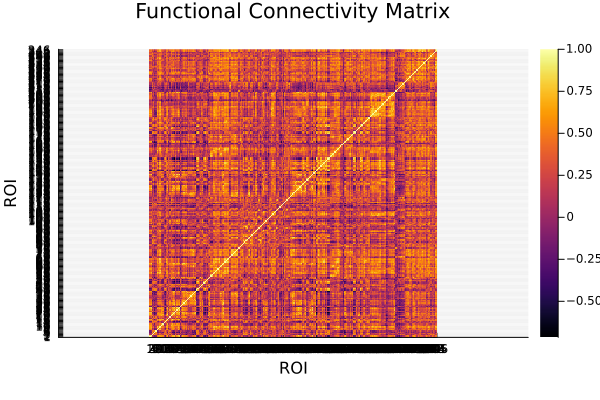

In [18]:
n = size(fc_mat, 1)

heatmap(
    fc_mat;
    aspect_ratio = 1,          # square
    xlabel       = "ROI",      
    ylabel       = "ROI",
    xticks       = (1:n, string.(1:n)),
    yticks       = (1:n, string.(1:n)),
    title        = "Functional Connectivity Matrix",
    colorbar     = true
)

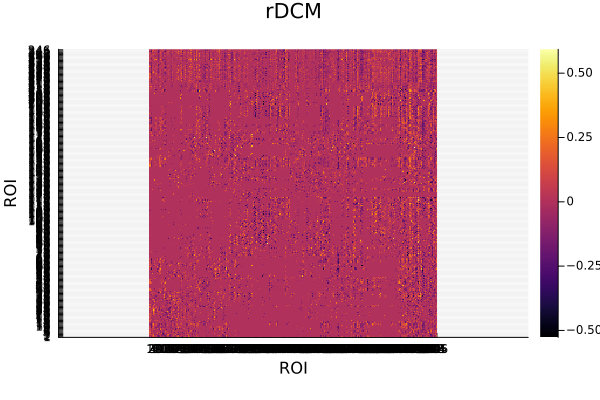

In [19]:
n = size(output.m_all, 1)

heatmap(
    output.m_all;
    aspect_ratio = 1,          # square
    xlabel       = "ROI",      
    ylabel       = "ROI",
    xticks       = (1:n, string.(1:n)),
    yticks       = (1:n, string.(1:n)),
    title        = "rDCM",
    colorbar     = true
)